# Fast Statistics for SSA Trajectories

Bioscrape has a couple of cythonized functions that quickly compute helpful statistics like means, correlations, and marginal distributions from SSA trajectories. This notebook shows how to use these functions.

In [2]:
# Create an example model of a Bistable Toggle Switch
from bioscrape.types import Model

species = ["G0", "R0", "G0R1", "G1", "R1", "G1R0", "T0", "T1"]

#Some fairly arbitrary parameters
ktx = 10.0
ktl = 10.0
delta = 2.
kb = 1000.
ku = 100.
n = 2
k_leak = ktx/200

reactions = [
    #Transcription: G_i --> G_i + T_i
    (["G0"], ["G0", "T0"], "massaction", {"k":ktx}), (["G1"], ["G1", "T1"], "massaction", {"k":ktx}),
    #Translation: T_i --> T_i + R_i
    (["T0"], ["R0", "T0"], "massaction", {"k":ktl}), (["T1"], ["R1", "T1"], "massaction", {"k":ktl}),
    #Repression: n R_i + G_j --> G_j:R_i
    (n*["R1"]+["G0"], ["G0R1"], "massaction", {"k":kb}), (n*["R0"]+["G1"], ["G1R0"], "massaction", {"k":kb}),
    (["G0R1"], n*["R1"]+["G0"], "massaction", {"k":ku}), (["G1R0"], n*["R0"]+["G1"], "massaction", {"k":ku}),
    # Degredation: R_i --> 0; T_i --> 0
    (["R0"], [], "massaction", {"k":delta}), (["R1"], [], "massaction", {"k":delta}),
    (["T0"], [], "massaction", {"k":delta}), (["T1"], [], "massaction", {"k":delta}),
    # Leak: G_j:R_i --> G_j:R_i + T_j
    (["G0R1"], ["G0R1", "T0"], "massaction", {"k":k_leak}), (["G1R0"], ["G1R0", "T1"], "massaction", {"k":k_leak}),
]

#initial condition
x0 = {s:0 for s in species}
x0.update({"G0":1, "G1":1})

CRN = Model(species = species, reactions = reactions, initial_condition_dict = x0)


### Simulate the model and return an SSA result instead of a dataframe

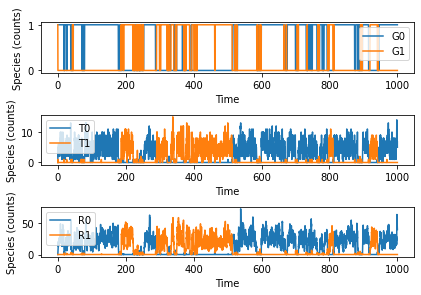

In [8]:
import pylab as plt
import numpy as np
from bioscrape.simulator import py_simulate_model

maxtime = 1000
dt = .1
timepoints = np.arange(0, maxtime, dt)

#Simulate the Model
R = py_simulate_model(timepoints, CRN, return_dataframe = False, stochastic = True)

# Create a dataframe from an SSA result
DF = R.py_get_dataframe(Model = CRN)
fig = plt.figure()
plt.subplot(311)
plt.plot(timepoints, DF["G0"], label = "G0")
plt.plot(timepoints, DF["G1"], label = "G1")
plt.ylabel("Species (counts)")
plt.xlabel("Time")
plt.legend()

plt.subplot(312)
plt.plot(timepoints, DF["T0"], label = "T0")
plt.plot(timepoints, DF["T1"], label = "T1")
plt.ylabel("Species (counts)")
plt.xlabel("Time")
plt.legend()

plt.subplot(313)
plt.plot(timepoints, DF["R0"], label = "R0")
plt.plot(timepoints, DF["R1"], label = "R1")
plt.ylabel("Species (counts)")
plt.xlabel("Time")
plt.legend()
fig.tight_layout(w_pad = 2)

### Compute Means, Standard Deviations, Correlations, and Second Moments using the SSAresult

Means +/- Standard Deviations
<G0> = 0.4192 +/- 0.4934281710644466
<R0> = 10.6044 +/- 13.279280878119527
<G0R1> = 0.5808 +/- 0.4934281710644466
<G1> = 0.4163 +/- 0.49294453034797875
<R1> = 10.7029 +/- 13.77763519585237
<G1R0> = 0.5837 +/- 0.49294453034797875
<T0> = 2.1208 +/- 2.768394364970534
<T1> = 2.1315 +/- 2.8568177663268317


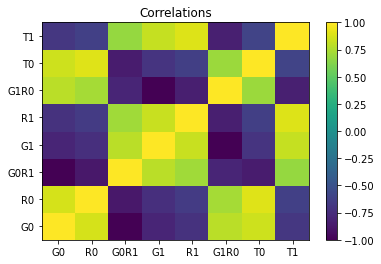

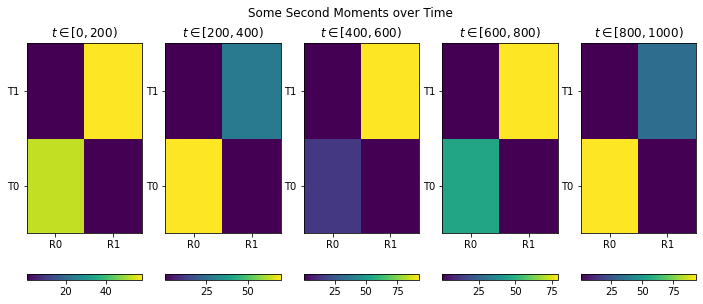

In [6]:
#compute the mean of all species
means = R.py_first_moment(Model = CRN)

#compute the means of some species
meansR = R.py_first_moment(Model = CRN, species = ["R0", "R1"])

stds = R.py_standard_deviation(Model = CRN)

print("Means +/- Standard Deviations")
for i in range(len(species)):
    print(f"<{species[i]}> =", means[i], "+/-", stds[i])

#compute correlations between all species after some amount of burn_in time
burn_in = int(maxtime/2)
cors = R.py_correlations(Model = CRN, start_time = burn_in)

cb = plt.pcolor(cors, vmin = -1, vmax = 1)
plt.colorbar(cb)
plt.xticks(np.arange(.5, len(species), 1), species)
plt.yticks(np.arange(.5, len(species), 1), species)
plt.title("Correlations")


#compute the correlations of some species during a small piece of the simulation
plt.figure(figsize = (12, 5))
plt.suptitle("Some Second Moments over Time")
nbins = 5
for i in range(nbins):
    step = int(maxtime/nbins)
    moms = R.py_second_moment(Model = CRN, species1= ["T0", "T1"], species2 = ["R0", "R1"], start_time = i*step, final_time = (i+1)*step-dt)

    plt.subplot(100+nbins*10+i+1)
    plt.title("$t\in ["+str(i*step)+","+ str((i+1)*step)+")$")
    cb = plt.pcolor(moms)
    plt.colorbar(cb, orientation = 'horizontal')
    plt.xticks([.5, 1.5], ["R0", "R1"])
    plt.yticks([.5, 1.5], ["T0", "T1"])



### Computer Marginal Distributions

[0.5808 0.4192] [0.5837 0.4163]


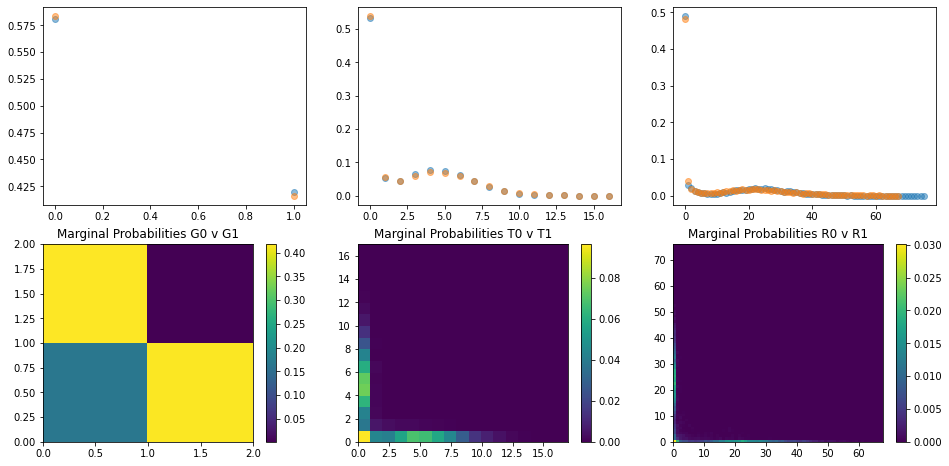

In [4]:
#compute marginal distributions of just one species

margG0 = R.py_empirical_distribution(species = ["G0"], Model = CRN)
margG1 = R.py_empirical_distribution(species = ["G1"], Model = CRN)


#can set the max count say the marginals have the same size
maxT = max(np.max(DF["T0"]), np.max(DF["T1"]))
margT0 = R.py_empirical_distribution(species = ["T0"], Model = CRN, max_counts = [maxT])
margT1 = R.py_empirical_distribution(species = ["T1"], Model = CRN, max_counts = [maxT])


margR0 = R.py_empirical_distribution(species = ["R0"], Model = CRN)
margR1 = R.py_empirical_distribution(species = ["R1"], Model = CRN)

plt.figure(figsize = (16, 8))
plt.subplot(231)
print(margG0, margG1)
plt.plot(margG0, 'o', label = "G0 Marginal", alpha = .5)
plt.plot(margG1, 'o', label = "G1 Marginal", alpha = .5)

plt.subplot(232)
plt.plot(margT0, 'o', label = "T0 Marginal", alpha = .5)
plt.plot(margT1, 'o', label = "T1 Marginal", alpha = .5)

plt.subplot(233)
plt.plot(margR0, 'o', label = "R0 Marginal", alpha = .5)
plt.plot(margR1, 'o', label = "R1 Marginal", alpha = .5)


#Compute marginal distributions over multiple species
hmG = R.py_empirical_distribution(species = ["G0", "G1"], Model = CRN)
hmT = R.py_empirical_distribution(species = ["T0", "T1"], Model = CRN, max_counts = [maxT, maxT])
hmR = R.py_empirical_distribution(species = ["R0", "R1"], Model = CRN)

plt.subplot(234)
plt.title("Marginal Probabilities G0 v G1")
cb = plt.pcolor(hmG)
plt.colorbar(cb)

plt.subplot(235)
plt.title("Marginal Probabilities T0 v T1")
cb = plt.pcolor(hmT)
plt.colorbar(cb)

plt.subplot(236)
plt.title("Marginal Probabilities R0 v R1")
cb = plt.pcolor(hmR)
plt.colorbar(cb)

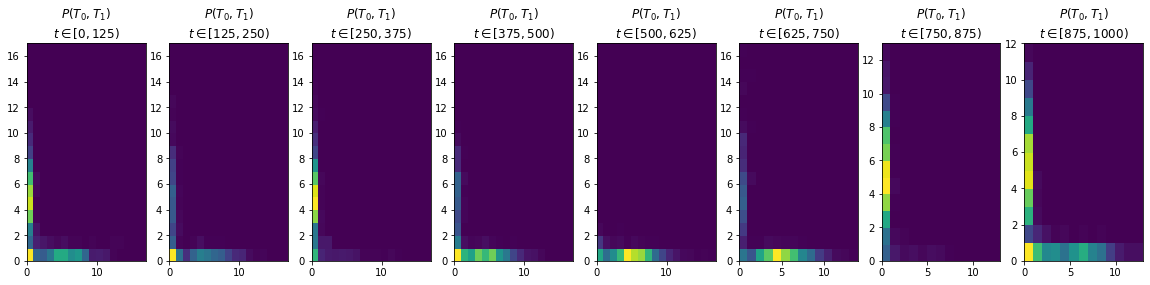

In [5]:
#Compute marginal distributions in bints overtime
plt.figure(figsize = (20, 4))
marg_list = []
nbins = 8
for i in range(nbins):
    step = int(maxtime/nbins)
    hmr = R.py_empirical_distribution(species = ["T0", "T1"], Model = CRN, start_time = i*step, final_time = (i+1)*step-dt)
    plt.subplot(100+nbins*10+i+1)
    plt.title("$P(T_0, T_1)$\n"+"$t\in ["+str(i*step)+","+ str((i+1)*step)+")$")
    plt.pcolor(hmr)